In [25]:
import pandas as pd

troll_df = pd.read_csv('Datasets/russian_troll_tweets/tweets.csv')
print(troll_df.shape)
troll_df.head(5)

(203482, 16)


,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN
2,1.710805e+09,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,NaN,[],[],POSTED,[],NaN,NaN
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,8.134006e+17,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,NaN,[],[],POSTED,[],NaN,NaN


We can see that the tweet data has 203,482 rows and 16 columns. It captures various data, including the *userid*, *tweetid*, *tweet text*, *hashtags*, *mentions*, and the number of retweets or favourites per tweet. There is also a datetime column *created_str*.

In [26]:
# Checking for missing values in the troll_df dataframe
troll_df.isnull().sum()
troll_df.isnull().sum().sort_values(ascending=False)

in_reply_to_status_id    202923
retweeted_status_id      163831
retweet_count            145399
retweeted                145399
favorite_count           145399
source                   145398
user_id                    8065
tweet_id                   2314
created_at                   21
created_str                  21
text                         21
user_key                      0
hashtags                      0
expanded_urls                 0
posted                        0
mentions                      0
dtype: int64

In the text column, there are 21 missing values. This is *the* critical column to be analysed in this project, thereforeany rows with nulls/NaNs in the text column will be dropped.

In [27]:
# Drop NaNs in the text column and update the troll_df dataframe
print(f"Number of tweets before dropping NaNs: {len(troll_df['text'])}")
troll_df.dropna(subset=['text'], inplace=True)
print(f"Number of tweets after dropping NaNs: {len(troll_df['text'])}")

Number of tweets before dropping NaNs: 203482
Number of tweets after dropping NaNs: 203461


In [28]:
# Checking the data types of the columns in the troll_df dataframe
troll_df.dtypes

user_id                  float64
user_key                  object
created_at               float64
created_str               object
retweet_count            float64
retweeted                 object
favorite_count           float64
text                      object
tweet_id                 float64
source                    object
hashtags                  object
expanded_urls             object
posted                    object
mentions                  object
retweeted_status_id      float64
in_reply_to_status_id    float64
dtype: object

The following observations:
1. *user_id*, *tweet_id*, *retweeted_status_id*, and *in_reply_to_status_id* have been read into the dataframe as a float. These need to be object data type, because we do not want computations on this column.

2. The *created_str* has been imported as object data type - we need to change this to datetime for further processing.

In [29]:
# Convert created_str to datetime format
troll_df['created_str'] = pd.to_datetime(troll_df['created_str'])

# Convert all '_id' columns to object datatype
columns = ['user_id', 'tweet_id', 'retweeted_status_id', 'in_reply_to_status_id']

for column in columns:
    troll_df[column] = troll_df[column].astype('object')

In [30]:
troll_df.dtypes

user_id                          object
user_key                         object
created_at                      float64
created_str              datetime64[ns]
retweet_count                   float64
retweeted                        object
favorite_count                  float64
text                             object
tweet_id                         object
source                           object
hashtags                         object
expanded_urls                    object
posted                           object
mentions                         object
retweeted_status_id              object
in_reply_to_status_id            object
dtype: object

A quick check confirms that the problem columns in troll_df have been successfully converted to the required datatypes.

But now we need to check the period of tweets captured in this dataset - to do this, we will use the *created_str* column (now in datetime format).

In [31]:
start_date_tweet = troll_df['created_str'].min()
end_date_tweet = troll_df['created_str'].max()

print(start_date_tweet)
print(end_date_tweet)

2014-07-14 18:04:55
2017-09-26 09:05:32


There are roughly 3 years of tweets in this dataset, starting from **14th July 2014** until **26th September 2017**. 

This datetime column contains the times when these tweets were posted, which we will remove by creating a new column - *created_str_date* - that only contains the date.

In [32]:
troll_df['created_str_date'] = pd.to_datetime(troll_df['created_str'].dt.date)
troll_df['created_str_date'].head()

0   2016-03-22
1   2016-10-10
2   2017-02-22
3   2016-12-26
4   2017-08-06
Name: created_str_date, dtype: datetime64[ns]

Each row is one tweet on any given date. To find out the number of tweets posted on a particular day, we simply need to count the number of times that a date appears in the *created_str_date* column.

In [33]:
# Count the number of times a date appears in the dataset and convert to dataframe
tweet_trend = pd.DataFrame(troll_df['created_str_date'].value_counts())
tweet_trend

,created_str_date
2016-10-06,3861
2016-09-17,3063
2016-11-08,2867
2016-09-19,2587
2016-09-18,2367
...,...
2015-02-05,1
2015-09-08,1
2015-05-24,1
2014-08-04,1


In [34]:
# tweet_trend index column is the date - the 'count' column indicates the tweet count for each day
tweet_trend.columns = ['tweet_count']
tweet_trend.sort_index(ascending=True, inplace=True)
tweet_trend.head()

,tweet_count
2014-07-14,1
2014-07-17,1
2014-07-20,2
2014-07-22,3
2014-07-23,1


Plotting line graph of the tweet count data with both *matplotlib* and *plotly express* (for extra practice).

In [35]:
import plotly.express as px

fig = px.line(tweet_trend, x=tweet_trend.index, y='tweet_count', title='Tweet counts by date')
fig.update_traces(line=dict(color='black', width=1))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Tweet Count',
    title_font_size=15,
    xaxis_tickangle=45,
    font=dict(size=13),
    width=600,
    height=400
)
fig.show()

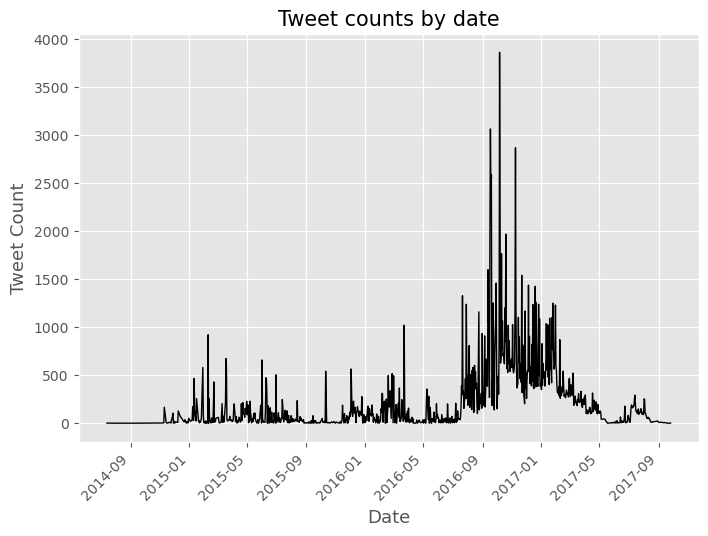

In [36]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
tweet_trend['tweet_count'].plot(linestyle='-', figsize=(8,6), rot=45, color='k', linewidth=1)
plt.title('Tweet counts by date', fontsize=15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Tweet Count', fontsize=13)
plt.show()

These line graphs are quite suggestive, but why? The noticeable spikes in the number of tweets might be linked to the 2016 presidential campaign. 

But how would we know if these tweets had an impact on the outcome of the US presidential elections? 

Put simply, these tweets would be most numerous during important parts of the election, and particularly at milestones in the 'Trump Rally'. 

Read through the following 'Reuters' article, which outlines the [important dates in Donald Trump's presidential election campaign.](https://www.reuters.com/article/us-usa-election-timeline-factbox/timeline-pivotal-moments-in-trumps-presidential-campaign-idUSKBN1341FJ)

In [37]:
# These are the days corresponding to important dates from the Trump election campaign. 
list_of_dates = ['2015-06-16', '2015-12-07', '2016-02-01', 
                        '2016-03-01', '2016-03-03', '2016-03-11',
                        '2016-05-03', '2016-05-26', '2016-06-20', 
                        '2016-07-15', '2016-07-21', '2016-08-17',
                        '2016-09-01', '2016-10-07', '2016-11-08']

# Convert the list into a series
important_dates = pd.Series(pd.to_datetime(list_of_dates))

In [38]:
# Add columns to identify important dates with a 0 or 1
tweet_trend['Important Events'] = False
tweet_trend.loc[important_dates, 'Important Events'] = True
tweet_trend['values'] = 0
tweet_trend.loc[important_dates, 'values'] = 1

# Show the updated dataframe
tweet_trend.head()

,tweet_count,Important Events,values
2014-07-14,1,False,0
2014-07-17,1,False,0
2014-07-20,2,False,0
2014-07-22,3,False,0
2014-07-23,1,False,0


Now that we have updated the dataframe, we should plot this data to identify the monthly average of tweet counts with red dots to mark important events

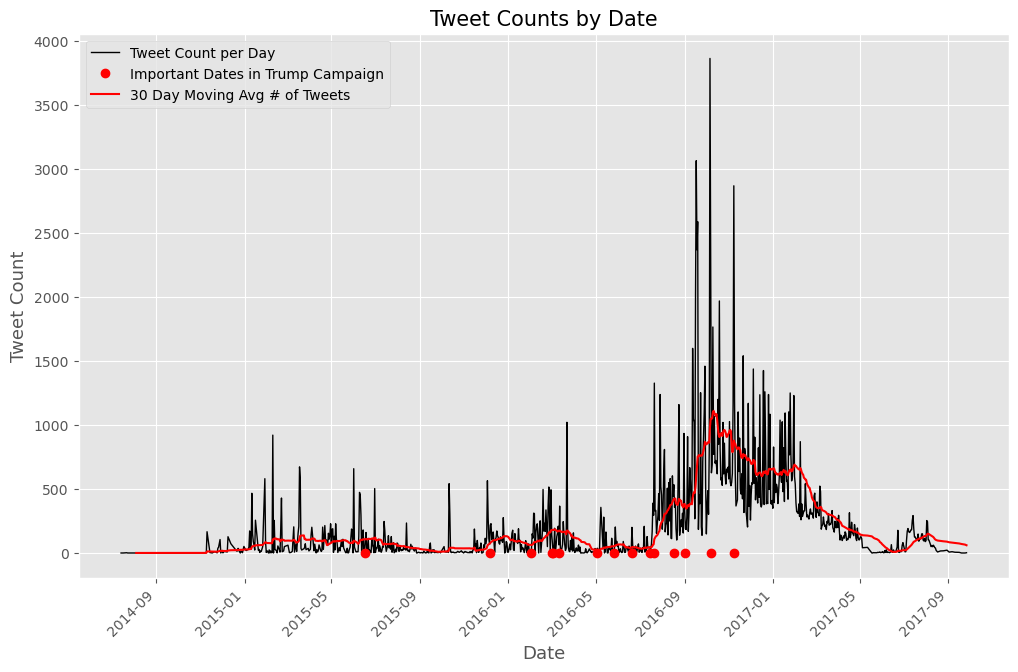

In [39]:
plt.style.use('ggplot')
tweet_trend['tweet_count'].plot(
    linestyle='-',
    figsize=(12, 8),
    rot=45,
    color='k',
    label='Tweet Count per Day',
    linewidth=1
)

# Plot dots for those days where values in the tweet_trend dataframe are 1
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker='o',
         color='r',
         linestyle='none',
         label='Important Dates in Trump Campaign',
         )

# Add a 30 day moving average on top of the graph to view the trend
plt.plot(tweet_trend['tweet_count'].rolling(window=30, min_periods=10).mean(),
                     color='r',
                     label='30 Day Moving Avg # of Tweets')
plt.title('Tweet Counts by Date', fontsize=15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Tweet Count', fontsize=13)
plt.legend(loc='best')

Donald Trump was elected as US president on 8th November 2016, which is the last red dot on the chart. There is lots of tweet activity in the weeks preceding and following this day. 

We can calculate the percentage change in tweet counts between subsequent dates to see if an important date is connected with a spike.

In [40]:
# Calculate percentage change in tweet counts
tweet_trend['pct_chg_tweets'] = tweet_trend['tweet_count'].pct_change()*100
tweet_trend['pct_chg_tweets'].head()

2014-07-14           NaN
2014-07-17      0.000000
2014-07-20    100.000000
2014-07-22     50.000000
2014-07-23    -66.666667
Name: pct_chg_tweets, dtype: float64

In [41]:
# Show percentage change in tweets for the important dates compared to the previous day
tweet_trend.loc[tweet_trend['values'] == 1, ['tweet_count', 'pct_chg_tweets']]

,tweet_count,pct_chg_tweets
2015-06-16,3,50.000000
2015-12-07,219,204.166667
2016-02-01,18,1700.000000
2016-03-01,143,-71.052632
2016-03-03,6,-92.105263
2016-03-11,64,-69.523810
2016-05-03,38,216.666667
2016-05-26,6,-50.000000
2016-06-20,201,1156.250000
2016-07-15,47,17.500000


For most of these dates, there was an increase in the tweet counts - some as large as 1150 and 1700 - but there were negative changes as well. It is important to remember that these were the dates of an important event, and the percentage changes refer to the previous day.

Text(0, 0.5, 'Tweet Count % Change')

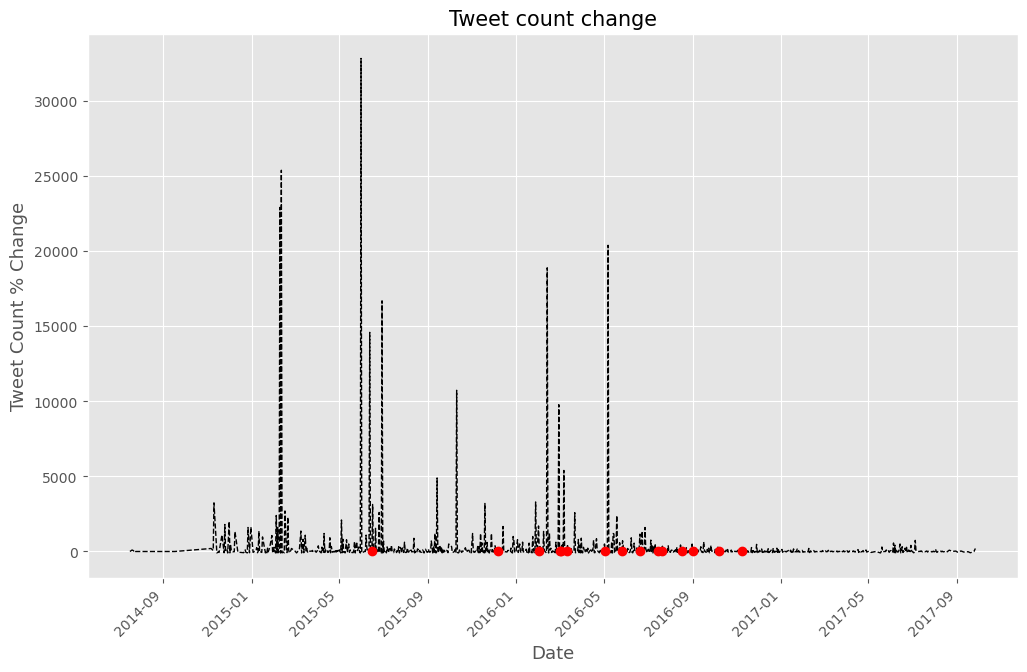

In [42]:
# Plot the percentage change in tweet counts to identify signs of correlation
plt.style.use('ggplot')

tweet_trend['pct_chg_tweets'].plot(
    linestyle='--',
    figsize=(12, 8),
    rot=45,
    color='k',
    linewidth=1
    )

# Add reds for important events
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker='o',
         color='r',
         linestyle='none')

plt.title('Tweet count change', fontsize=15),
plt.xlabel('Date', fontsize=13)
plt.ylabel('Tweet Count % Change', fontsize=13)

### Tweet Text Analysis

The tweets contain extra elements, such as RT mentions ('@'), links, and hashtags. We need to separate these elements, so that we can analyse *only* the tweet text, or *only* the hashtags - whatever we prefer.

In [43]:
troll_df['text'].head(10)

0    #IslamKills Are you trying to say that there w...
1    Clinton: Trump should’ve apologized more, atta...
2    RT @ltapoll: Who was/is the best president of ...
3    RT @jww372: I don't have to guess your religio...
4    RT @Shareblue: Pence and his lawyers decided w...
5                               @ModicaGiunta me, too!
6    RT @MDBlanchfield: You’ll never guess who twee...
7    RT @100PercFEDUP: New post: WATCH: DIAMOND AND...
8    RT @AriaWilsonGOP: 3 Women Face Charges After ...
9    One of the ways to remind that #BlackLivesMatt...
Name: text, dtype: object

The table above contains the first ten tweets. It gives us the following information:
1. **Retweets** begin with the keyword 'RT', which are followed by the *@userkey*.
2. **Hashtags** begin with a # and always consist of a single, continuous string with an adjacent space.
3. **Links** begin with *https://* or *http://* and can be present anywhere in the tweet text.
4. A single tweet can contain multiple links and hashtags, but only one retweet identifier.
5. **User mentions** begin with '@' and consist of a single, continuous word.

In [44]:
import regex as re

# Step 1: Remove the RT mentions from tweets
def remove_retweet(tweet):
    '''Given a tweet, remove the retweet element from it.'''
    no_retweets_text = []
    if len(re.findall('^RT.*?:(.*)', tweet)) > 0:
        no_retweets_text.append(re.findall('^RT.*?:(.*)', tweet)[0])
    else:
        no_retweets_text.append(tweet)
    return no_retweets_text[0]

text_no_retweets = troll_df['text'].map(remove_retweet)

In [45]:
# Check the 'text_only' series for the absence of 'RT' mentions
text_no_retweets

0         #IslamKills Are you trying to say that there w...
1         Clinton: Trump should’ve apologized more, atta...
2          Who was/is the best president of the past 25 ...
3          I don't have to guess your religion! #Christm...
4          Pence and his lawyers decided which of his of...
                                ...                        
203477     In intel circles, the story goes FSB filmed T...
203478     Tonganoxie police: Middle school girl sexuall...
203479     Getting the right #company logo: How #busines...
203480    The Latest: Obama affirms continuity of ties w...
203481     U cant just Upload a CD online &amp; thats it...
Name: text, Length: 203461, dtype: object

In [46]:
# Step 2: Remove the links from tweets
def remove_links(tweet):
    '''Given a tweet, remove the links from it.'''
    no_links_text = []
    if len(re.findall('(https://[^\s]+)', tweet)) > 0:
        tweet = re.sub('(https://[^\s]+)', '', tweet)
    if len(re.findall('(http://[^\s]+)', tweet)) > 0:
        tweet = re.sub('(http://[^\s]+)', '', tweet)
    no_links_text.append(tweet)
    return no_links_text[0]

text_no_links = text_no_retweets.map(remove_links)

In [47]:
# Step 3: Remove hashtags from tweets
def remove_hashtags(tweet):
    '''Given a tweet, remove the hashtags from it.'''
    no_hashtags_text = []
    if len(re.findall('(#[^#\s]+)', tweet)) > 0:
        tweet = re.sub('(#[^#\s]+)', '', tweet)
    no_hashtags_text.append(tweet)
    return no_hashtags_text[0]

text_no_hashtags = text_no_links.map(remove_hashtags)

In [48]:
# Step 4: Remove extraneous characters
def remove_extraneous(tweet):
    '''Given a tweet, remove unnecessary characters from the beginning and the end.'''
    tweet=tweet.rstrip()
    tweet=tweet.lstrip()
    tweet=tweet.rstrip(')')
    tweet=tweet.lstrip('(')
    tweet=re.sub('\.', '', tweet)
    return tweet

text_clean = text_no_hashtags.map(remove_extraneous)

At this point, we need to remove the user mentions from the text_clean. But this might be useful information for later in the project, so we will store the user mentions in a new dataframe column.

In [49]:
# Step 5a: Extract and store the user mentions
def extract_mentions(tweet):
    '''Given a tweet, extract and store the user mentions.'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet)) > 0:
        mentions.append(re.findall('@([^\s@]+)', tweet))
    else:
        mentions.append(['0'])
    return mentions[0]

troll_df['user_mentions'] = text_clean.map(extract_mentions)

In [50]:
# Step 5b: Remove the user mentions from the tweet text
def remove_mentions(tweet):
    'Given a tweet, remove the user mentions.'
    mentions = []
    if len(re.findall('@[^\s@]+', tweet)) > 0:
        tweet = re.sub('@[^\s@]+', '', tweet)
        mentions.append(tweet)
    else:
        mentions.append(tweet)
    return mentions[0]

final_text_clean = text_clean.map(remove_mentions)

Some final checks to ensure that troll_df is the same length, and now contains a column with the cleaned text.

In [51]:
print(f"There are {len(troll_df)} tweets in the dataset.")

final_text_clean.head(5)

There are 203461 tweets in the dataset.


0    Are you trying to say that there were no terro...
1    Clinton: Trump should’ve apologized more, atta...
2    Who was/is the best president of the past 25 y...
3                 I don't have to guess your religion!
4    Pence and his lawyers decided which of his off...
Name: text, dtype: object

In [52]:
# Append the cleaned text to the troll_df dataframe
troll_df['tweet_text_only'] = final_text_clean
troll_df.head(5)

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id,created_str_date,user_mentions,tweet_text_only
0,1868981054.0,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,712346027861405696.0,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN,2016-03-22,[0],Are you trying to say that there were no terro...
1,2571870453.0,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",785584942356967424.0,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN,2016-10-10,[0],"Clinton: Trump should’ve apologized more, atta..."
2,1710804738.0,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,834383165359788032.0,NaN,[],[],POSTED,[],NaN,NaN,2017-02-22,[0],Who was/is the best president of the past 25 y...
3,2584152521.0,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,813400649912217600.0,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN,2016-12-26,[0],I don't have to guess your religion!
4,1768259989.0,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,894024327049363456.0,NaN,[],[],POSTED,[],NaN,NaN,2017-08-06,[0],Pence and his lawyers decided which of his off...


It is worth pointing out that we have not removed the hashtags, RT mentions, links, and user mentions from the original 'text' column in troll_df. 

This is important, because we might want to conduct some analysis of the tweet-specific syntax, particularly hashtags.

A question that I would like to answer is, "What hashtags are being used the most by Russian trolls?" 

To find out the answer, we need to amend the function above to extract (NOT remove!) the hashtags.

In [53]:
def extract_hashtags(tweet):
    '''Given a tweet, extract and store the hashtags.'''
    hashtags_only = []
    if len(re.findall('(#[^#\s]+)', tweet)) > 0:
        hashtags_only.append(re.findall('(#[^#\s]+)', tweet))
    else:
        hashtags_only.append(['0'])
    return hashtags_only[0]

troll_df['tweet_hashtags'] = troll_df['text'].map(extract_hashtags)
troll_df['tweet_hashtags'].head(10)

0                          [#IslamKills]
1                                    [0]
2                                    [0]
3                  [#ChristmasAftermath]
4                                    [0]
5                                    [0]
6                                    [0]
7                                    [0]
8                                    [0]
9    [#BlackLivesMatter, #BlackPressDay]
Name: tweet_hashtags, dtype: object

In [54]:
# Extract unique hashtags from this new troll_df column and take a value count
all_hashtags = troll_df['tweet_hashtags'].tolist()
all_hashtags

[['#IslamKills'],
 ['0'],
 ['0'],
 ['#ChristmasAftermath'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['#BlackLivesMatter', '#BlackPressDay'],
 ['#myfarewellwordswouldbe'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['#My2017BiggestHope'],
 ['#Obama'],
 ['#1'],
 ['0'],
 ['0'],
 ['#politics'],
 ['0'],
 ['#TexasJihad'],
 ['#DayWithoutImmigrants'],
 ['#Islamisten', '#ISIS'],
 ['0'],
 ['#StopIslam', '#IslamKills'],
 ['0'],
 ['#Friyay'],
 ['0'],
 ['0'],
 ['0'],
 ['#ItsRiskyTo'],
 ['0'],
 ['#whenthestarsgoblue', '#RejectedDebateTopics'],
 ['#mutual', '#respect'],
 ['#SearchesGoogleIsAshamedOf'],
 ['0'],
 ['0'],
 ['#OneLetterOffSports', '#HashtagWars'],
 ['#God', '#religions...'],
 ['0'],
 ['#KSHBC'],
 ['#MAGA'],
 ['#SuperBowl'],
 ['0'],
 ['0'],
 ['0'],
 ['#Armageddon'],
 ['0'],
 ['#ToDoListBeforeChristmas'],
 ['#2017trendsreport', '#Excellent', '#RT', '#UrgentAction'],
 ['0'],
 ['#Merkel', '#Deutschland'],
 ['0'],
 ['#Palestinian', '#Arab', '#terrorist', '#Jerusalem'],
 ['#BlacksForTrump'],
 ['0'],
 ['

We can observe above that all_hashtags is a list of lists, which we need to change.

In [55]:
# Flatten the list of lists
cleaned_hashtags = []
for i in all_hashtags:
    for x in i:
        cleaned_hashtags.append(x)

cleaned_hashtags

['#IslamKills',
 '0',
 '0',
 '#ChristmasAftermath',
 '0',
 '0',
 '0',
 '0',
 '0',
 '#BlackLivesMatter',
 '#BlackPressDay',
 '#myfarewellwordswouldbe',
 '0',
 '0',
 '0',
 '0',
 '#My2017BiggestHope',
 '#Obama',
 '#1',
 '0',
 '0',
 '#politics',
 '0',
 '#TexasJihad',
 '#DayWithoutImmigrants',
 '#Islamisten',
 '#ISIS',
 '0',
 '#StopIslam',
 '#IslamKills',
 '0',
 '#Friyay',
 '0',
 '0',
 '0',
 '#ItsRiskyTo',
 '0',
 '#whenthestarsgoblue',
 '#RejectedDebateTopics',
 '#mutual',
 '#respect',
 '#SearchesGoogleIsAshamedOf',
 '0',
 '0',
 '#OneLetterOffSports',
 '#HashtagWars',
 '#God',
 '#religions...',
 '0',
 '#KSHBC',
 '#MAGA',
 '#SuperBowl',
 '0',
 '0',
 '0',
 '#Armageddon',
 '0',
 '#ToDoListBeforeChristmas',
 '#2017trendsreport',
 '#Excellent',
 '#RT',
 '#UrgentAction',
 '0',
 '#Merkel',
 '#Deutschland',
 '0',
 '#Palestinian',
 '#Arab',
 '#terrorist',
 '#Jerusalem',
 '#BlacksForTrump',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '#BlacksForTrump',
 '#MakeAmericaGreatAgain',
 '#Blacks4Trump…',
 '0',
 '0

In [56]:
# Convert cleaned_hashtags to a series and count the most frequent hashtags
cleaned_hashtags_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtags_series.value_counts()
hashtag_counts

0                 102547
#politics           3638
#tcot               2799
#MAGA               2306
#PJNET              2121
                   ...  
#Reading               1
#BookWorm              1
#InHerOwnWords         1
#Vigi…                 1
#businesses            1
Length: 28641, dtype: int64

We will create a wordcloud of the most commonly used hashtags, which requires that we put the word list as a single string separated by spaces.

The algorithm counts the number of times that each hashtag is used, then increases the size and boldness of the word(s) according to frequency.

In [57]:
# Convert the pandas series to a NumPy array, then convert to list
hashtags = cleaned_hashtags_series.values
hashtags = hashtags.tolist()

# Convert list to a single string with all the words
hashtag_words = ''.join(hashtags)
hashtag_words

'#IslamKills00#ChristmasAftermath00000#BlackLivesMatter#BlackPressDay#myfarewellwordswouldbe0000#My2017BiggestHope#Obama#100#politics0#TexasJihad#DayWithoutImmigrants#Islamisten#ISIS0#StopIslam#IslamKills0#Friyay000#ItsRiskyTo0#whenthestarsgoblue#RejectedDebateTopics#mutual#respect#SearchesGoogleIsAshamedOf00#OneLetterOffSports#HashtagWars#God#religions...0#KSHBC#MAGA#SuperBowl000#Armageddon0#ToDoListBeforeChristmas#2017trendsreport#Excellent#RT#UrgentAction0#Merkel#Deutschland0#Palestinian#Arab#terrorist#Jerusalem#BlacksForTrump000000#BlacksForTrump#MakeAmericaGreatAgain#Blacks4Trump…000000#ValentinesDayIn3Words#MakeAmericaGreatAgain00#Guns4NY#PrayForFlorida00#ChildrenThinkThat#MyBestFriendIsntAllowed00#HateToEatAndRun,0#IslamKills#ParisAttacks#Brussels00000#EDQ#ferguson00000#RT#RT#CCOT#TCOT#Cleveland#politics#Iamonfire#TedCruz#DeathByDemocrat#Linksextremismus#G20#NoG20#ObamasWishList#Debate#ThankACop#LawEnforc…00#StayWoke#BlackExcellence#BlackHistoryMonth00#WakeUpAmerica#sports0#Reje

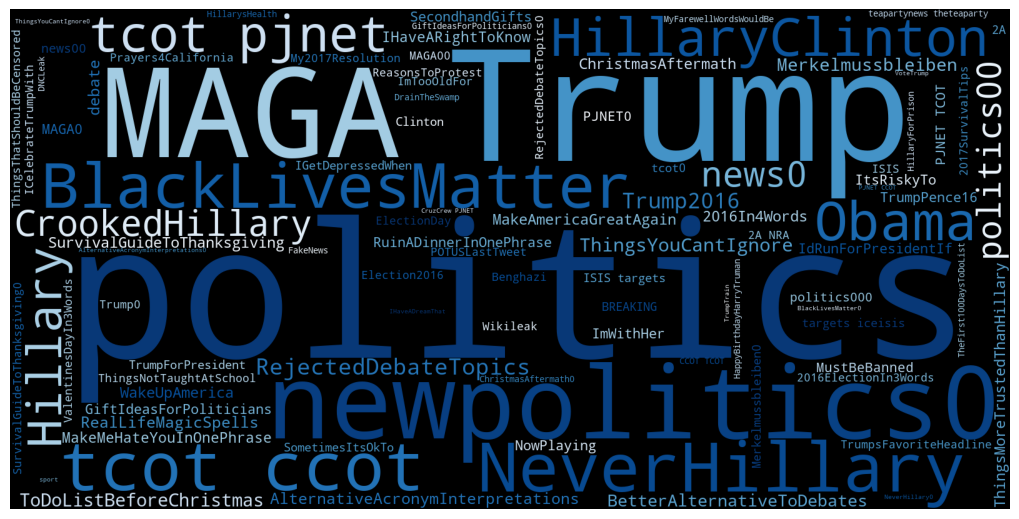

In [58]:
# Generate the wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,
                      relative_scaling=1.0,
                      colormap='Blues',
                      max_words=100).generate(hashtag_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

With this wordcloud, we can quickly identify the most common hashtags. But how could we better identify the frequency of each hashtag? We should also create a barplot to show this information.

Text(0, 0.5, 'Hashtags')

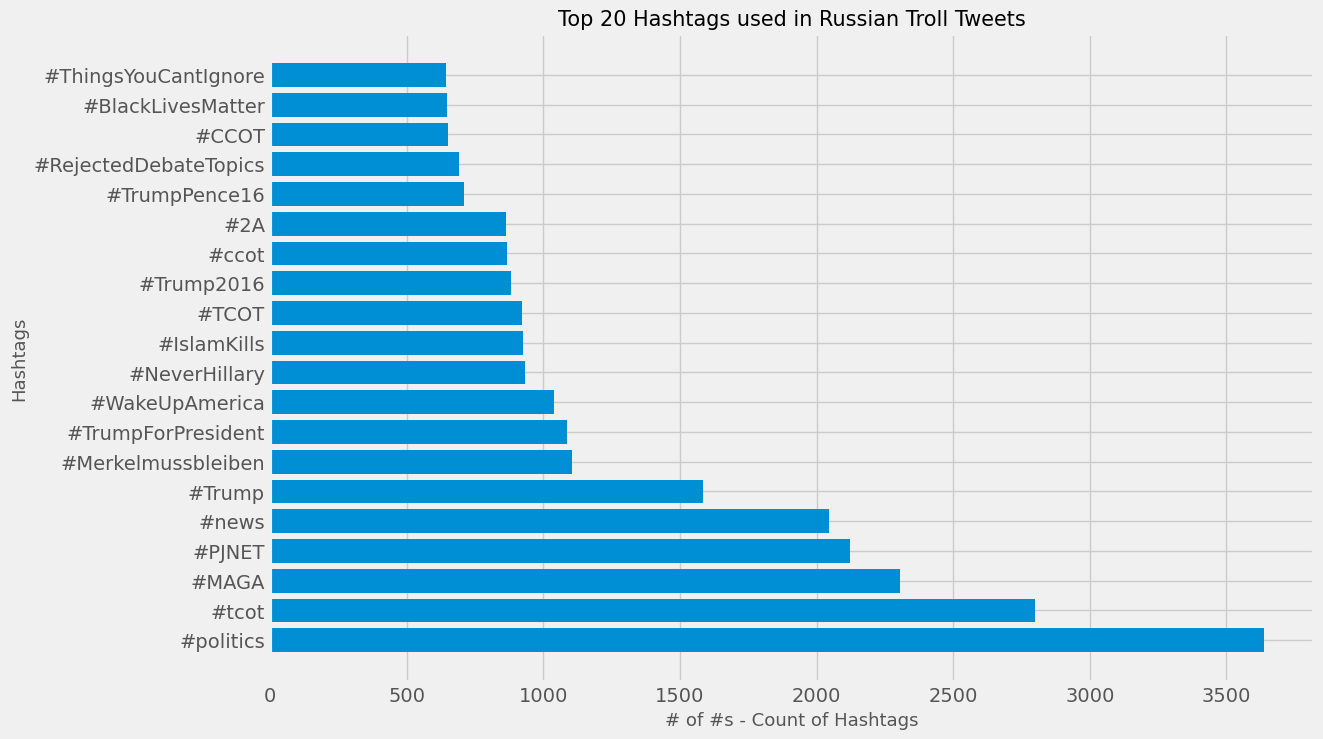

In [59]:
# Plot the top 20 hashtags and their counts
plt.style.use('fivethirtyeight')
plt.figure(figsize = (12,8))
plt.barh(y = hashtag_counts[1:21].index.values, width = hashtag_counts[1:21])
plt.title('Top 20 Hashtags used in Russian Troll Tweets', fontsize = 15)
plt.xlabel('# of #s - Count of Hashtags', fontsize = 13)
plt.ylabel('Hashtags', fontsize = 13)

#### What are the most common hashtags used by Russian trolls?

1. **#politics** 
2. **#tcot** (Top Conservatives on Twitter)
3. **#MAGA** (Make America Great Again)
4. **#PJNET** (Patriot Journalist Network)
5. **#news** 
6. **#Trump** (codename of a lesser-known 20th century villain)

All of these are supportive of Trump's presidential campaign. On this basis, it seems likely that the Russian trolls were mostly tweeting in support of Trump's candidacy for US president.

A quirky (and, as a Germanist, dare I say amusing) hashtag that has appeared in the top 20 is '#Merkelmussbleiben', which is in support of the former German chancellor, Angela Merkel. In German, it translates to 'Merkel must stay'.

What could this mean? Given the current context (in 2024 AD), and the glacial but now inevitable German shift away from Russian gas and permitted involvement (read: lobbying) in Teutonic politics... let the reader understand.

#### When were these hashtags used? Were they mostly used prior to the 2016 presidential campaign?

In [60]:
# Create a dataframe that only contains the date and tweet hashtags used (on that particular day)
hashtag_date_df = troll_df[['created_str_date', 'tweet_hashtags']]
hashtag_date_df = hashtag_date_df.reset_index(drop=True)

list_of_hashtags = hashtag_date_df['tweet_hashtags'].tolist()

hashtag_date_df.head()

,created_str_date,tweet_hashtags
0,2016-03-22,[#IslamKills]
1,2016-10-10,[0]
2,2017-02-22,[0]
3,2016-12-26,[#ChristmasAftermath]
4,2017-08-06,[0]


In [61]:
# Calculate how many times each of the top 10 hashtags appears with each date
count_dict = {}

for i in hashtag_counts.index.values[1:11]: # Top 10 hashtags
    count_hash = [] # List to store counts for each of the Top 10 hashtags
    for hashtag in list_of_hashtags: # Enumerate through all hashtags in hashtag_date_df
        count_hash.append(hashtag.count(i)) # Count number of times each Top 10 hashtag appears
    count_dict[i] = count_hash # Add the count to the dictionary

In [62]:
# Create a dataframe from the hashtags
hashtag_count_df = pd.DataFrame(count_dict)

# Concatenate this dataframe with the hashtag_date_df
hashtag_count_df = pd.concat([hashtag_date_df, hashtag_count_df], axis = 1)

hashtag_count_df.head()

,created_str_date,tweet_hashtags,#politics,#tcot,#MAGA,#PJNET,#news,#Trump,#Merkelmussbleiben,#TrumpForPresident,#WakeUpAmerica,#NeverHillary
0,2016-03-22,[#IslamKills],0,0,0,0,0,0,0,0,0,0
1,2016-10-10,[0],0,0,0,0,0,0,0,0,0,0
2,2017-02-22,[0],0,0,0,0,0,0,0,0,0,0
3,2016-12-26,[#ChristmasAftermath],0,0,0,0,0,0,0,0,0,0
4,2017-08-06,[0],0,0,0,0,0,0,0,0,0,0


In the table above, each of the columns represents a hashtag, whilst each cell beneath reports the number of times that this specific hashtag appeared. Each complete row represents a specific date, such as 22nd March 2016 (2016-03-22). 

With this table, we can more clearly see the usage frequency of the Russian trolls' ten favourite hashtags on particular days. So what next? We need to summarise the data on the monthly level, in order to better understand the **month-by-month** usage of these top 10 hashtags.

In [63]:
# Change the 'created_str-date' column to datetime and extract the date
hashtag_count_df['created_str_date'] = pd.to_datetime(hashtag_count_df['created_str_date'])

# Set the index in order to plot the time series
hashtag_count_df.set_index('created_str_date', inplace=True)

# Calculate the monthly sum of tweets for each hashtag
hashtag_monthly_count_df = hashtag_count_df.resample('M').sum()

/var/folders/7_/1sj7vc495_z4fzf1l_tpnznc0000gn/T/ipykernel_6967/3089012174.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [64]:
import numpy as np

# Replace 0 with nan, so that wee can remove rows with only null values
print(f'Length of the dataframe before cleaning nulls: {len(hashtag_monthly_count_df)}')
hashtag_monthly_count_df.replace(0, np.nan, inplace=True)

Length of the dataframe before cleaning nulls: 39


In [66]:
hashtag_monthly_count_df

,#politics,#tcot,#MAGA,#PJNET,#news,#Trump,#Merkelmussbleiben,#TrumpForPresident,#WakeUpAmerica,#NeverHillary
created_str_date,,,,,,,,,,
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2015-03-31,1.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN


In [67]:
# hashtag_monthly_count_df.drop(columns='tweet_hashtags', inplace=True)
hashtag_monthly_count_df.dropna(how='all', inplace=True, axis=0)
print(f'Length of the dataframe after removing null rows: {len(hashtag_monthly_count_df)}')

Length of the dataframe after removing null rows: 31


In [68]:
hashtag_monthly_count_df

,#politics,#tcot,#MAGA,#PJNET,#news,#Trump,#Merkelmussbleiben,#TrumpForPresident,#WakeUpAmerica,#NeverHillary
created_str_date,,,,,,,,,,
2015-02-28,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2015-03-31,1.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN
2015-04-30,45.0,4.0,NaN,2.0,149.0,NaN,NaN,NaN,6.0,NaN
2015-05-31,41.0,30.0,NaN,64.0,163.0,NaN,NaN,NaN,53.0,NaN
2015-06-30,26.0,61.0,NaN,17.0,124.0,NaN,NaN,NaN,23.0,NaN
2015-07-31,59.0,13.0,NaN,3.0,307.0,2.0,NaN,NaN,7.0,NaN
2015-08-31,3.0,1.0,NaN,1.0,9.0,24.0,NaN,11.0,5.0,NaN
2015-09-30,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2015-10-31,20.0,34.0,NaN,11.0,1.0,6.0,NaN,NaN,11.0,NaN


In [69]:
# Return NaN values to zeroes to plot the time series
hashtag_monthly_count_df.fillna(0, inplace=True)
hashtag_monthly_count_df

,#politics,#tcot,#MAGA,#PJNET,#news,#Trump,#Merkelmussbleiben,#TrumpForPresident,#WakeUpAmerica,#NeverHillary
created_str_date,,,,,,,,,,
2015-02-28,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2015-03-31,1.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
2015-04-30,45.0,4.0,0.0,2.0,149.0,0.0,0.0,0.0,6.0,0.0
2015-05-31,41.0,30.0,0.0,64.0,163.0,0.0,0.0,0.0,53.0,0.0
2015-06-30,26.0,61.0,0.0,17.0,124.0,0.0,0.0,0.0,23.0,0.0
2015-07-31,59.0,13.0,0.0,3.0,307.0,2.0,0.0,0.0,7.0,0.0
2015-08-31,3.0,1.0,0.0,1.0,9.0,24.0,0.0,11.0,5.0,0.0
2015-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-10-31,20.0,34.0,0.0,11.0,1.0,6.0,0.0,0.0,11.0,0.0


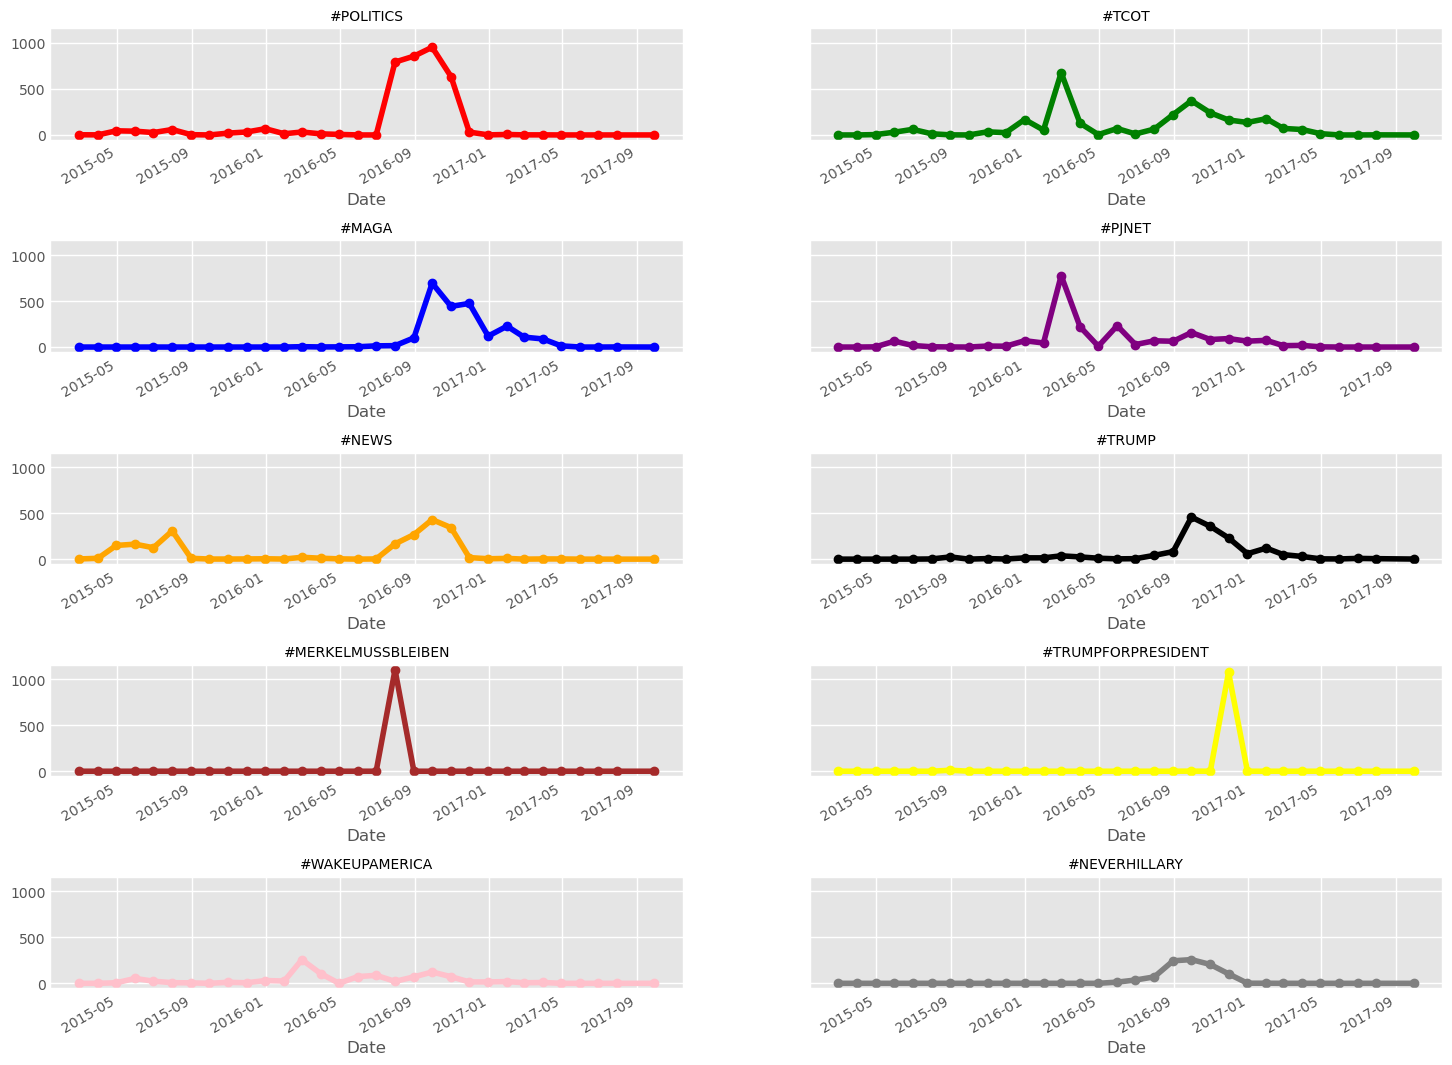

In [70]:
plt.style.use('ggplot')

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5,
                                                                                 ncols=2,
                                                                                 sharey=True,
                                                                                 figsize=(16, 12))

plt.subplots_adjust(top=1, hspace=0.9)
# Plot the first of the top 10 hashtags
hashtag_monthly_count_df['#politics'].plot(linestyle='-', marker='o', color='red', ax=ax1)
ax1.set_title('#POLITICS', fontsize=10)
ax1.set_xlabel('Date', fontsize=12)

# Plot the second of the top 10 hashtags
hashtag_monthly_count_df['#tcot'].plot(linestyle='-', marker='o', color='green', ax=ax2)
ax2.set_title('#TCOT', fontsize=10)
ax2.set_xlabel('Date', fontsize=12)

# Plot the third of the top 10 hashtags
hashtag_monthly_count_df['#MAGA'].plot(linestyle='-', marker='o', color='blue', ax=ax3)
ax3.set_title('#MAGA', fontsize=10)
ax3.set_xlabel('Date', fontsize=12)

# Plot the fourth of the top 10 hashtags
hashtag_monthly_count_df['#PJNET'].plot(linestyle='-', marker='o', color='purple', ax=ax4)
ax4.set_title('#PJNET', fontsize=10)
ax4.set_xlabel('Date', fontsize=12)

# Plot the fifth of the top 10 hashtags
hashtag_monthly_count_df['#news'].plot(linestyle='-', marker='o', color='orange', ax=ax5)
ax5.set_title('#NEWS', fontsize=10)
ax5.set_xlabel('Date', fontsize=12)

# Plot the sixth of the top 10 hashtags
hashtag_monthly_count_df['#Trump'].plot(linestyle='-', marker='o', color='black', ax=ax6)
ax6.set_title('#TRUMP', fontsize=10)
ax6.set_xlabel('Date', fontsize=12)

# Plot the seventh of the top 10 hashtags
hashtag_monthly_count_df['#Merkelmussbleiben'].plot(linestyle='-', marker='o', color='brown', ax=ax7)
ax7.set_title('#MERKELMUSSBLEIBEN', fontsize=10)
ax7.set_xlabel('Date', fontsize=12)

# Plot the eigth of the top 10 hashtags
hashtag_monthly_count_df['#TrumpForPresident'].plot(linestyle='-', marker='o', color='yellow', ax=ax8)
ax8.set_title('#TRUMPFORPRESIDENT', fontsize=10)
ax8.set_xlabel('Date', fontsize=12)

# Plot the ninth of the top 10 hashtags
hashtag_monthly_count_df['#WakeUpAmerica'].plot(linestyle='-', marker='o', color='pink', ax=ax9)
ax9.set_title('#WAKEUPAMERICA', fontsize=10)
ax9.set_xlabel('Date', fontsize=12)

# Plot the tenth of the top 10 hashtags
hashtag_monthly_count_df['#NeverHillary'].plot(linestyle='-', marker='o', color='grey', ax=ax10)
ax10.set_title('#NEVERHILLARY', fontsize=10)
ax10.set_xlabel('Date', fontsize=12)

plt.show()

It is clear to see that most of these hashtags appeared in the year 2016 near March or later in July - close to the elections. Incidentally, this is also the time period when alleged interference by Russian trolls began.

The largest peak can be seen in the #politics - perhaps the Russian trolls got the most views, influence, and following by tweeting about this topic.

In [71]:
sentiment_tweets = pd.read_csv('Datasets/sentiment140_tweet_dataset.csv', encoding='ISO-8859-1', header=None)

In [72]:
sentiment_tweets.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [73]:
sentiment_tweets.columns = ['sentiment', 'id', 'date', 'query', 'username', 'tweet_text']

sentiment_tweets['cleaned_text'] = sentiment_tweets['tweet_text'].map(remove_mentions)
sentiment_tweets['cleaned_text'] = sentiment_tweets['cleaned_text'].map(remove_hashtags)
sentiment_tweets['cleaned_text'] = sentiment_tweets['cleaned_text'].map(remove_links)
sentiment_tweets['cleaned_text'] = sentiment_tweets['cleaned_text'].map(remove_retweet)
sentiment_tweets['cleaned_text'] = sentiment_tweets['cleaned_text'].map(remove_extraneous)

sentiment_tweets.head()

,sentiment,id,date,query,username,tweet_text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer You shoulda got David..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all i'm mad why am i ..."


In [74]:
sentiment_tweets.tail()

,sentiment,id,date,query,username,tweet_text,cleaned_text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Just woke up Having no school is the best feel...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,TheWDBcom - Very cool to hear old Walt intervi...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...,happy


In [75]:
not_troll_df = pd.DataFrame(sentiment_tweets['cleaned_text'])
not_troll_df['label'] = 0
not_troll_df.rename(columns = {'cleaned_text':'tweet_text_only'}, inplace = True)
not_troll_df.head()

,tweet_text_only,label
0,"- Awww, that's a bummer You shoulda got David...",0
1,is upset that he can't update his Facebook by ...,0
2,I dived many times for the ball Managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all i'm mad why am i ...",0


In [76]:
normie_df = pd.DataFrame(troll_df['tweet_text_only'])
normie_df['label'] = 1
normie_df.head()

,tweet_text_only,label
0,Are you trying to say that there were no terro...,1
1,"Clinton: Trump should’ve apologized more, atta...",1
2,Who was/is the best president of the past 25 y...,1
3,I don't have to guess your religion!,1
4,Pence and his lawyers decided which of his off...,1


In [77]:
not_troll_sample = not_troll_df.sample(n=len(normie_df), random_state=42)
not_troll_sample.head()

,tweet_text_only,label
541200,AHHH I HOPE YOUR OK!!!,0
750,"cool , i have no tweet apps for my razr 2",0
766711,i know just family drama its lamehey next tim...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [78]:
training_df = pd.concat([normie_df, not_troll_sample])
training_df.reset_index(inplace=True, drop=True)
training_df.head()
print(f"Number of labels: {training_df['label'].value_counts()}")

Number of labels: 1    203461
0    203461
Name: label, dtype: int64


In [79]:
training_df.head()

,tweet_text_only,label
0,Are you trying to say that there were no terro...,1
1,"Clinton: Trump should’ve apologized more, atta...",1
2,Who was/is the best president of the past 25 y...,1
3,I don't have to guess your religion!,1
4,Pence and his lawyers decided which of his off...,1


NOTE: Get Thanos meme.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

### Vectorizer and Train_Test_Split

In [81]:
count_vec = CountVectorizer(stop_words='english', max_features=5000)
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=5000)

# CountVectorizer feature engineering
count_X = count_vec.fit_transform(training_df['tweet_text_only'])
y = training_df['label']

count_X_train, count_X_test, count_y_train, count_y_test = train_test_split(count_X, y, test_size=0.2, random_state=42, stratify=y)

# TfidfVectorizer feature engineering
tfidf_X = tfidf_vec.fit_transform(training_df['tweet_text_only'])
y = training_df['label']

tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

In [105]:
# Selecting and training LogRes model
logres_model = LogisticRegression(max_iter=1000)

count_logres_model = logres_model.fit(count_X_train, count_y_train)
tfidf_logres_model = logres_model.fit(tfidf_X_train, tfidf_y_train)

In [106]:
# CountVectorizer model evaluation
count_logres_y_pred = count_logres_model.predict(count_X_test)
print(classification_report(count_y_test, count_y_pred))
print(confusion_matrix(count_y_test, count_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     40693
           1       0.91      0.78      0.84     40692

    accuracy                           0.85     81385
   macro avg       0.86      0.85      0.85     81385
weighted avg       0.86      0.85      0.85     81385

[[37452  3241]
 [ 9028 31664]]


In [107]:
# TfidfVectorizer model evaluation
tfidf_logres_y_pred = tfidf_logres_model.predict(tfidf_X_test)
print(classification_report(tfidf_y_test, tfidf_y_pred))
print(confusion_matrix(tfidf_y_test, tfidf_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87     40693
           1       0.87      0.86      0.86     40692

    accuracy                           0.87     81385
   macro avg       0.87      0.87      0.87     81385
weighted avg       0.87      0.87      0.87     81385

[[35515  5178]
 [ 5804 34888]]


### Naive Bayes

In [101]:
from sklearn.naive_bayes import MultinomialNB

# Selecting and training Naive Bayes model
nb_model = MultinomialNB()

count_nb_model = nb_model.fit(count_X_train, count_y_train)
tfidf_nb_model = nb_model.fit(tfidf_X_train, tfidf_y_train)

count_nb_y_pred = count_nb_model.predict(count_X_test)
tfidf_nb_y_pred = tfidf_nb_model.predict(tfidf_X_test)

### Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Increase to 500 if time allows
count_rf_model = rf_model.fit(count_X_train, count_y_train)
tfidf_rf_model = rf_model.fit(tfidf_X_train, tfidf_y_train)

In [100]:
count_rf_y_pred = count_rf_model.predict(count_X_test)
tfidf_rf_y_pred = tfidf_rf_model.predict(tfidf_X_test)

### XGBoost

In [102]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
count_xgb_model = xgb_model.fit(count_X_train, count_y_train)
tfidf_xgb_model = xgb_model.fit(tfidf_X_train, tfidf_y_train)

count_xgb_y_pred = count_xgb_model.predict(count_X_test)
tfidf_xgb_y_pred = tfidf_xgb_model.predict(tfidf_X_test)

### Support Vector Classifier

In [114]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

# Initialize the StandardScaler
scaler = MaxAbsScaler()
svc_model = SVC(kernel='linear', max_iter=1000)

# Fit and transform your training data
count_X_train_scaled = scaler.fit_transform(count_X_train)
tfidf_X_train_scaled = scaler.fit_transform(tfidf_X_train)

# Transform your test data using the same scaler
count_X_test_scaled = scaler.transform(count_X_test)
tfidf_X_test_scaled = scaler.transform(tfidf_X_test)

# Fit SVC models to the scaled training data
count_svc_model = svc_model.fit(count_X_train_scaled, count_y_train)
tfidf_svc_model = svc_model.fit(tfidf_X_train_scaled, tfidf_y_train)

# Make predictions
count_svc_y_pred = count_svc_model.predict(count_X_test_scaled)
tfidf_svc_y_pred = tfidf_svc_model.predict(tfidf_X_test_scaled)

/Users/benjaminlucas/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/Users/benjaminlucas/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



These were the different results after experimenting with different scaler strategies on the SVC model:

1. **No Scaler:**
CountVec SVC: 65.2% / TfidfVec SVC: 56.19%

2. **StandardScaler:**
CountVec SVC: 60.16% / TfidfVec SVC: 53.02%

3. **MaxAbsScaler:**
CountVec SVC: 65.20% / TfidfVec SVC: 56.19%

### Model Accuracy

In [117]:
# Comparison of Model Accuracy 

from sklearn.metrics import accuracy_score

count_acc_logres = accuracy_score(count_y_test, count_logres_y_pred)
tfidf_acc_logres = accuracy_score(tfidf_y_test, tfidf_logres_y_pred)

count_acc_nb = accuracy_score(count_y_test, count_nb_y_pred)
tfidf_acc_nb = accuracy_score(tfidf_y_test, tfidf_nb_y_pred)

count_acc_rf = accuracy_score(count_y_test, count_rf_y_pred)
tfidf_acc_rf = accuracy_score(tfidf_y_test, tfidf_rf_y_pred)

count_acc_xgb = accuracy_score(count_y_test, count_xgb_y_pred)
tfidf_acc_xgb = accuracy_score(tfidf_y_test, tfidf_xgb_y_pred)

count_acc_svc = accuracy_score(count_y_test, count_svc_y_pred)
tfidf_acc_svc = accuracy_score(tfidf_y_test, tfidf_svc_y_pred)

"""count_acc_gb = accuracy_score(count_y_test, count_y_pred)
tfidf_acc_gb = accuracy_score(tfidf_y_test, tfidf_y_pred)"""

print("Model accuracy:")
print(f"CountVec Logres: {count_acc_logres*100:.3f}%")
print(f"TfidfVec Logres: {tfidf_acc_logres*100:.3f}%")

print(f"CountVec Naive Bayes: {count_acc_nb*100:.3f}%")
print(f"TfidfVec Naive Bayes: {tfidf_acc_nb*100:.3f}%")

print(f"CountVec Random Forest: {count_acc_rf*100:.3f}%")
print(f"TfidfVec Random Forest: {tfidf_acc_rf*100:.3f}%")

print(f"CountVec XGBoost: {count_acc_xgb*100:.3f}%")
print(f"TfidfVec XGBoost: {tfidf_acc_xgb*100:.3f}%")

print(f"CountVec SVC: {count_acc_svc*100:.3f}%")
print(f"TfidfVec SVC: {tfidf_acc_svc*100:.3f}%")

Model accuracy:
CountVec Logres: 84.925%
TfidfVec Logres: 86.506%
CountVec Naive Bayes: 85.613%
TfidfVec Naive Bayes: 85.447%
CountVec Random Forest: 81.588%
TfidfVec Random Forest: 86.311%
CountVec XGBoost: 79.323%
TfidfVec XGBoost: 81.247%
CountVec SVC: 65.202%
TfidfVec SVC: 56.188%


Based on the accuracy results from the models above, the top 3 models are the following:
1. TfidfVec Logres: 86.51%
2. TfidfVec Random Forest: 86.31%
3. CountVec Naive Bayes: 85.61%

### BERT Vectorizer and Model Testing

Now I need to run the code for a BERT model and see if the accuracy is any better. If I have time, I could create a Keras model and play around with some deeep learning.